In [264]:
#import matplotlib.pyplot as plt
#import numpy as np
#import seaborn as sns
#import math
#from scipy import stats
#print("imported " + str(len(raw)) + " rows")
#raw.columns.tolist()

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import tabulate
import numpy as np
from matplotlib import cm
raw = pd.pandas.read_csv('../setup_data/pred_1x0_20181130.csv',sep=",",low_memory=False)

## Functions

def print_list(list_in):
    display(HTML(tabulate.tabulate(list_in, tablefmt='html')))

# Setup Data Set

In [265]:
### CLEAN DATA FUNC

def clean_func(data,predictors):
    
    ## DO IMPUTATION 
    # living_area
    floor = Imputer(missing_values="NaN", strategy="mean")
    floor.fit(data[["floor"]])
    data['floor'] = floor.transform(data[["floor"]]).ravel()
    
    ## REMOVE ROWS w. NULL
    data = data[pd.notnull(data[predictors]).all(axis=1)]
    return data


In [266]:
## set predictors
predictors = ['min_distance_to_metro','living_area'
              ,'floor','sqm_list_price','sqm_rent_price'
              ,'area_from_geo']

## set numeric predictors
num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64','uint8']
train_data_numerics = raw[predictors].select_dtypes(include=num_types).columns

In [267]:
## Set target and clean data (se function above)
target = 'sqm_sold_price'
train_data = clean_func(raw,predictors)

train_data_predictors = train_data[predictors]
train_data_target = train_data[target].values

# Try different Models

### Split Dataset

In [268]:
## Split Train/test
X_train, X_test, y_train, y_test = train_test_split(train_data_predictors, train_data_target, test_size=0.33, random_state=42)

### Linear Regression

In [269]:
## TRAIN MODEL
from sklearn import linear_model
lin_reg = linear_model.LinearRegression()

lin_reg.fit(X_train[train_data_numerics],y_train)

print("Coefficients")
print_list(list(zip(train_data_numerics,lin_reg.coef_)))

Coefficients


min_distance_to_metro,-1.18663
living_area,-141.889
floor,59.1866
sqm_list_price,1.07014
sqm_rent_price,-56.2497


In [270]:
## PREDICT
lin_reg_pred_y_test = lin_reg.predict(X_test[train_data_numerics])
lin_reg_pred_y_train = lin_reg.predict(X_train[train_data_numerics])


Mean error train:
5422.63486872
Mean error test:
5126.32507062


<IPython.core.display.Javascript object>


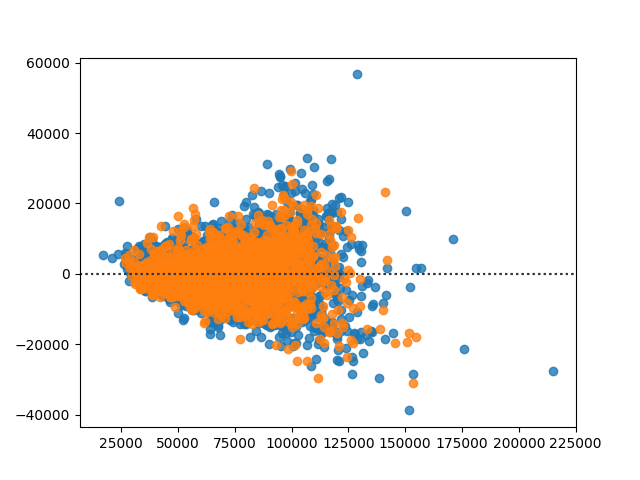

In [281]:
## METRICS
import seaborn as sns
errors_tets = (((y_test - lin_reg_pred_y_test)**2)**0.5)
errors_train = (((y_train - lin_reg_pred_y_train)**2)**0.5)
print("Mean error train:")
print(errors_train.mean())
print("Mean error test:")
print(errors_tets.mean())

%matplotlib notebook
sns.residplot(lin_reg_pred_y_train, y_train, label="train_error");
sns.residplot(lin_reg_pred_y_test, y_test, label="test_error");
plt.show()

### Random Forest Regressor

In [348]:
## TRAIN MODEL
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(max_depth=7, random_state=0, n_estimators=80)
rf_reg.fit(X_train[train_data_numerics],y_train)

print("Feature Importance")
print_list(list(zip(train_data_numerics,rf_reg.feature_importances_)))

Feature Importance


min_distance_to_metro,0.00637774
living_area,0.0409433
floor,0.00277084
sqm_list_price,0.944223
sqm_rent_price,0.00568534


In [349]:
## PREDICT
rf_reg_pred_y_test = rf_reg.predict(X_test[train_data_numerics])
rf_reg_pred_y_train = rf_reg.predict(X_train[train_data_numerics])


Mean error train:
4281.59226528
Mean error test:
4781.85924671
Explained variance score
0.920648275164


<IPython.core.display.Javascript object>


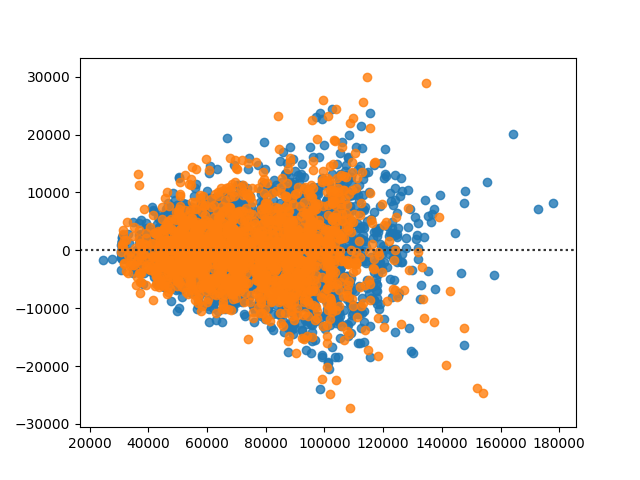

In [350]:
## METRICS
import seaborn as sns
errors_tets = (((y_test - rf_reg_pred_y_test)**2)**0.5)
errors_train = (((y_train - rf_reg_pred_y_train)**2)**0.5)
explained_variance_score = 1-np.var(y_test - rf_reg_pred_y_test)/np.var(y_test)
print("Mean error train:")
print(errors_train.mean())
print("Mean error test:")
print(errors_tets.mean())
print("Explained variance score")
print(explained_variance_score)

%matplotlib notebook
sns.residplot(rf_reg_pred_y_train, y_train, label="train_error");
sns.residplot(rf_reg_pred_y_test, y_test, label="test_error");
plt.show()

### GradientBoostingRegressor

In [251]:
## TRAIN MODEL
from sklearn.ensemble import GradientBoostingRegressor
gb_reg = GradientBoostingRegressor(n_estimators=30,learning_rate=0.1)#loss='quantile', learning_rate=0.0001, n_estimators=50, max_features='log2', min_samples_split=2, max_depth=1)
gb_reg.fit(X_train[train_data_numerics],y_train)

print("Feature Importance")
print_list(list(zip(train_data_numerics,gb_reg.feature_importances_)))


Feature Importance


min_distance_to_metro,0.0192185
living_area,0.135505
floor,0.000959025
sqm_list_price,0.824037
sqm_rent_price,0.0202805


In [252]:
## PREDICT
gb_reg_pred_y_test = gb_reg.predict(X_test[train_data_numerics])
gb_reg_pred_y_train = gb_reg.predict(X_train[train_data_numerics])


Mean error train:
5049.61671055
4105.40521557
Mean error test:
4989.94851688
3926.22758707


<IPython.core.display.Javascript object>


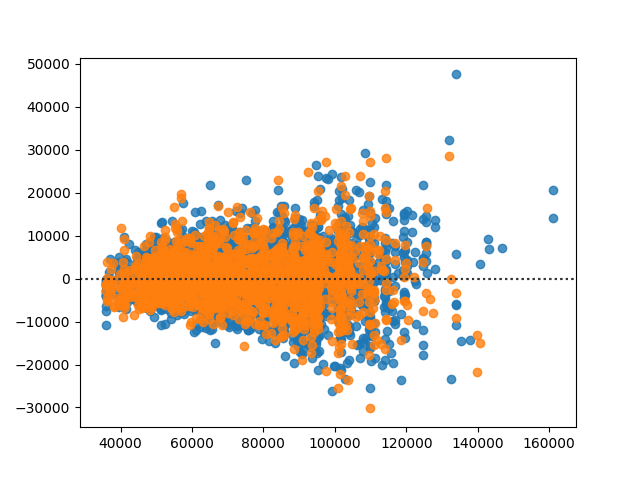

In [283]:
## METRICS
import seaborn as sns
errors_tets = (((y_test - gb_reg_pred_y_test)**2)**0.5) 
errors_train = (((y_train - gb_reg_pred_y_train)**2)**0.5) ## mean_squared_error(y_train,gb_reg_pred_y_train)
print("Mean error train:")
print(errors_train.mean())
print(np.median(errors_train))
print("Mean error test:")
print(errors_tets.mean())
print(np.median(errors_tets))

%matplotlib notebook
sns.residplot(gb_reg_pred_y_train, y_train, label="train_error");
sns.residplot(gb_reg_pred_y_test, y_test, label="test_error");
plt.show()

# Cross Validation

In [293]:
from sklearn.model_selection import cross_val_score
rf_reg = RandomForestRegressor(max_depth=7, random_state=0, n_estimators=70)
# scores sätts till explained_variance_score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.explained_variance_score.html

scores = cross_val_score(rf_reg, X_train[train_data_numerics], y_train, cv=5)#,scoring='neg_mean_squared_error')

In [294]:
print(np.sqrt(abs(scores)))

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.95670453  0.95536718  0.95959129  0.95273771  0.94756229]
Accuracy: 0.91 (+/- 0.02)


# Exhaustive Grid Search own dev

In [129]:
# create function that can make grid search for metaparameters
# Expected structure
# param_gs_gb = {
#     'model':GradientBoostingRegressor,
#     'hyper_param':{
#         'learning_rate': [0.12,0.1,0.08,0.06],
#         'n_estimators': [90, 100,110,120,130]
#     }
# }
from sklearn.ensemble import GradientBoostingRegressor
from mpl_toolkits.mplot3d import Axes3D


def grid_search(param_grid):
    hyper_param_names = list(param_grid['hyper_param'].keys())
    
    ## define empty 2d array to fill with eval metrics
    model_measures_test =  np.full((len(param_grid['hyper_param'][hyper_param_names[0]]), len(param_grid['hyper_param'][hyper_param_names[1]])), 0)
    model_measures_train =  np.full((len(param_grid['hyper_param'][hyper_param_names[0]]), len(param_grid['hyper_param'][hyper_param_names[1]])), 0)
    
    for i,param_1 in enumerate(param_grid['hyper_param'][hyper_param_names[0]]):
        for j,param_2 in enumerate(param_grid['hyper_param'][hyper_param_names[1]]):
            #create dict of parameters to call modeling function with
            parameters = {}
            parameters[hyper_param_names[0]] = param_1
            parameters[hyper_param_names[1]] = param_2
            
            # call the model given as input paramter, unpack parameters with **
            model = param_grid['model'](**parameters)
            model.fit(X_train[train_data_numerics],y_train)
            model_pred_y_test = model.predict(X_test[train_data_numerics])
            model_pred_y_train = model.predict(X_train[train_data_numerics])

            ### save errors to matrix
            model_output_test_res = (((y_test - model_pred_y_test)**2)**0.5).mean()
            model_output_train_res = (((y_train - model_pred_y_train)**2)**0.5).mean()
            model_measures_test[i,j] = model_output_test_res
            model_measures_train[i,j] = model_output_train_res
            
    return [model_measures_test,model_measures_train]

def plot_gs(param_gs,result_gs):
    from mpl_toolkits.mplot3d import Axes3D

    %matplotlib notebook
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    # Make data.
    xx, yy = np.meshgrid(np.asarray(param_gs['hyper_param'][list(param_gs['hyper_param'].keys())[1]]),np.asarray(param_gs['hyper_param'][list(param_gs['hyper_param'].keys())[0]]), sparse=True)
    
    # Plot the surface.
    ax.set_xlabel(list(param_gs['hyper_param'].keys())[1])
    ax.set_ylabel(list(param_gs['hyper_param'].keys())[0])
    ax.set_zlabel('mean pricing error')
    surf = ax.plot_surface(xx, yy, result_gs, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    



In [118]:
param_gs_rf = {
    'model':RandomForestRegressor,
    'hyper_param':{
        'max_depth': [6,7,8,9,10],
        'n_estimators': [40, 50, 60, 70]#, 80,90, 100]
    }
}
gs_rf = grid_search(param_gs_rf)

In [130]:
param_gs_gb = {
    'model':GradientBoostingRegressor,
    'hyper_param':{
        'learning_rate': [0.12,0.1,0.08,0.06],
        'n_estimators': [90, 100,110,120,130]
    }
}
gs_gb = grid_search(param_gs_gb)

<IPython.core.display.Javascript object>


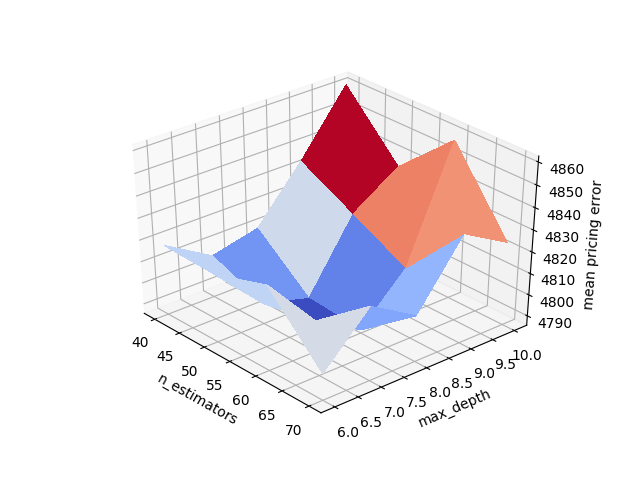

In [122]:
## Plot Grid Search for Random Forest Regressor
plot_gs(param_gs_rf,gs_rf)

<IPython.core.display.Javascript object>


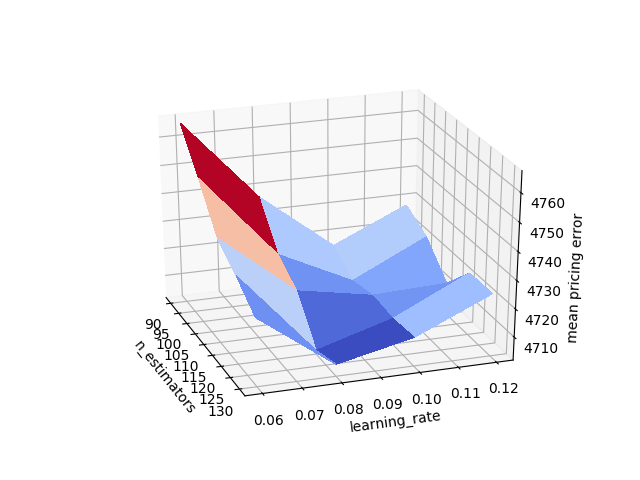

In [134]:
## Plot Grid Search for Gradient Boosting Regressor
plot_gs(param_gs_gb,gs_gb[0])


# Exhaustive Grid Search (GridSearchCV)

In [358]:
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth':[2,3,4,5,6,7], 'n_estimators':[20,30,40, 50, 60, 70, 80, 90, 100]}
gb_reg = GradientBoostingRegressor()
clf = GridSearchCV(test, parameters, cv=2,error_score='raise')

clf.fit(train_data_predictors[train_data_numerics], train_data_target)


#print(train_data_predictors.head())

#train_data_target


GridSearchCV(cv=2, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7], 'n_estimators': [20, 30, 40, 50, 60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [359]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_max_depth',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

In [375]:
clf.cv_results_['mean_test_score']

array([ 0.86560848,  0.89850187,  0.90870697,  0.91302231,  0.91480539,
        0.91576576,  0.91634071,  0.91667319,  0.91681831,  0.88954743,
        0.90947883,  0.9144802 ,  0.91583178,  0.91616191,  0.91649639,
        0.91638159,  0.91651166,  0.91657578,  0.89730911,  0.91306493,
        0.91591342,  0.91673554,  0.91699984,  0.91666779,  0.91632597,
        0.91626015,  0.91630442,  0.89942614,  0.91306853,  0.91493349,
        0.91491772,  0.91446716,  0.91431715,  0.91377621,  0.91351778,
        0.9131373 ,  0.8996366 ,  0.91153738,  0.91283953,  0.91225891,
        0.91164468,  0.91108161,  0.91089597,  0.91051851,  0.91028709,
        0.89748732,  0.90806644,  0.90870227,  0.90808646,  0.90731487,
        0.90684409,  0.90627446,  0.90610367,  0.90569659])

<IPython.core.display.Javascript object>


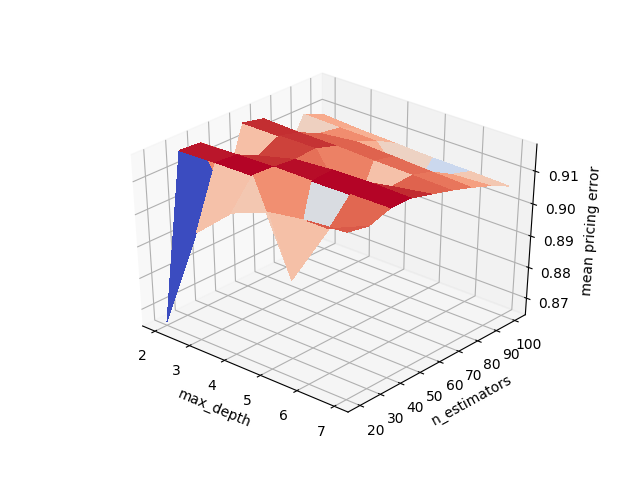

In [381]:
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook
fig = plt.figure()
ax = fig.gca(projection='3d')
# Make data.
xx, yy = np.meshgrid(np.asarray(clf.get_params()['param_grid']['max_depth']),np.asarray(clf.get_params()['param_grid']['n_estimators']), sparse=True)

# Plot the surface.
ax.set_xlabel('max_depth')
ax.set_ylabel('n_estimators')
ax.set_zlabel('mean pricing error')
surf = ax.plot_surface(xx, yy, clf.cv_results_['mean_test_score'].reshape(9,6), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

In [382]:
clf.best_params_

{'max_depth': 4, 'n_estimators': 60}